In [1]:
import pandas as pd
from matplotlib.pyplot import plot
from textblob import TextBlob

# config

In [2]:
cases_data = 'corona_lb_data.csv'
tweets_data = '..\\tweets_data.csv'
save_to = '..\\tweets_sentiment.csv'


pd.set_option('display.max_rows', 255)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# load tweets

In [3]:
tweets = pd.read_csv(tweets_data, header=0)
tweets.head()

,username,date,text,tags,translated_text,location,latitude,longitude,KADAA_ID,KADAA_AR,KADAA_EN,MOHAFAZA_ID,MOHAFAZA_AR,MOHAFAZA_EN
0,Fouad Badaro,2020-09-05,#Corona #COVIDー19 Official Numbers in Lebanon ...,"['#Corona', '#كورونا_لبنان', '#كورونا', '#Stay...",#Corona #COVIDー19 Official Numbers in Lebanon ...,بيروت,33.8719,35.5097,31000,بيروت,Beirut,3,بيروت,Beirut
1,الكابتين,2020-09-05,#كورونا_لبنان \n#coronavirus,"['#كورونا_لبنان', '#coronavirus']",# Corona_Lebanon\n#coronavirus,بيروت,33.8719,35.5097,31000,بيروت,Beirut,3,بيروت,Beirut
2,سفير الشمال,2020-09-05,إدارة منتجع “البالما” توضح.. ماذا قالت عن إصاب...,"['#لبنان', '#كورونا']","The management of the ""Palma"" resort explains ...",ارة,33.5403,35.3800,81000,صيدا,Saida,8,الجنوب,South
3,Jihad,2020-09-05,عاجل: وزارة الصحة اللبنانية: 415 إصابة كورونا...,['#كورونا_لبنان'],Urgent: The Lebanese Ministry of Health: 415 C...,حالات,34.0828,35.6541,56000,جبيل,Jbeil,5,جبل لبنان,Mount Lebanon
4,Ali H. Merii,2020-09-05,أخيرا بكرا ٧ ايلول بتخلص التعبئة العامة وبترجع...,['#كورونا_لبنان'],"Finally, the 7 of September gets rid of the ge...",المشحاة,34.0500,35.7250,55000,كسروان,Kesserouane,5,جبل لبنان,Mount Lebanon


# split date

In [4]:
tweets[['year', 'month', 'day']] = tweets.date.str.split('-', expand=True)

# get sentiment

In [5]:
def get_sentiments(row):
    text_sentiment = TextBlob(row.translated_text).sentiment.polarity
    
    sentiment_label = 'Neutral'
    if text_sentiment > 0:
        sentiment_label = 'Positive'
    elif text_sentiment < 0:
        sentiment_label = 'Negative'
    
    return pd.Series([text_sentiment, sentiment_label])

In [6]:
tweets[['sentiment', 'sentiment_label']] = tweets.apply(get_sentiments, axis=1)

# save

In [7]:
tweets.to_csv(save_to, index=False)

# statistics

In [8]:
config = {
    'month': 'first',
    'day': 'first',
    'sentiment': 'mean'
}
days = tweets.groupby(['month', 'day']).agg(config).reset_index(drop=True)
days

,month,day,sentiment
0,02,01,0.100376
1,02,02,0.083802
2,02,03,0.084910
3,02,04,0.057694
4,02,05,0.074575
5,02,06,0.052919
6,02,07,0.042819
7,02,08,0.013471
8,02,09,0.096655
9,02,10,0.036529


In [9]:
X = range(len(days))
sentiment = days.sentiment
Zero = [0 for x in X]

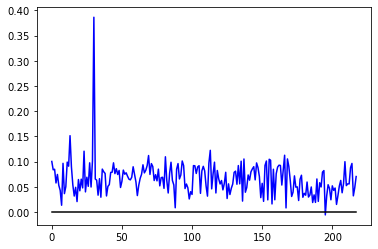

In [10]:
plot(X, sentiment, 'b', X, Zero, 'black')

# months statistics

In [11]:
config = {
    'month': 'first',
    'day': 'first',
    'sentiment': 'mean'
}
months = tweets.groupby('month').agg(config).reset_index(drop=True)
months

,month,day,sentiment
0,02,29,0.062686
1,03,31,0.079293
2,04,30,0.071298
3,05,31,0.062952
4,06,30,0.063733
5,07,31,0.059132
6,08,31,0.040589
7,09,05,0.067839


In [12]:
X = months.month
sentiment = months.sentiment
Zero = [0 for x in range(len(months.month))]

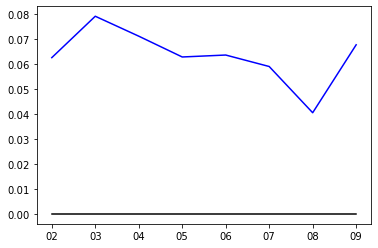

In [13]:
plot(X, sentiment, 'b', X, Zero, 'black')

# Observations

- The people sentiment curve.
- It visualize the change in people sentiment/view on corona over time.
- Useful for checking the people care about corona. 
- `y increase == people are more neutral or positve == they either don't care anymore or the situation is getting better`
